idea -> 

murmur 

학습 라벨
murmur 0 0 1 
unknown 0 1 0
absent 1 0 0
murmur 다른거 0.5 0.5

합칠 때: 
murmur 가 가장 높은 확률인 벡터 뽑기
murmur 확률 과 0, 0.5, 1 과의 거리의 역수를 합이 1이 되게 표준화시켜 점수만들기

학습라벨
- normal 1 0
- abnormal 
present 0.1 0.9
unknown 0.15 0.85
absent 0.2 0.8
합칠 때: 평균


    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']


In [9]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math

In [10]:
import sys
sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
#sys.path.insert(0,'/home/ikwak2/hmd/iy_classifier')
sys.path.insert(0,'/home/ikwak2/hmd/notebooks/utils')


In [11]:
from helper_code import *
from get_feature import *

In [12]:
root_dir = '/home/ikwak2/hmd/physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [13]:
import tensorflow as tf

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


Sat Jul  2 16:53:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   32C    P8    13W /

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [15]:
df = pd.read_csv(training_data_file)
df[:10]

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.90,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.10,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.10,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.90,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.20,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
6,23625,AV+PV+TV+MV,Child,Female,92.0,14.00,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,50379.0
7,24160,AV+PV+TV+MV,Child,Female,98.0,17.66,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
8,29045,AV+PV+TV+MV,Child,Female,88.0,12.50,False,Present,AV+MV+PV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
9,29378,AV+MV,Child,Female,82.0,10.70,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [16]:
data_folder =  '/home/ikwak2/hmd/physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_folder = '/home/ubuntu/data/hmd/murmur/test'
model_folder = 'tmp_model3'

In [17]:
data_folder

'/home/ikwak2/hmd/physionet.org/files/circor-heart-sound/1.0.3/training_data'

In [18]:
patient_files = find_patient_files(data_folder)
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

num_patient_files = len(patient_files)


In [19]:
!cat /home/ubuntu/data/hmd/murmur/train/46778.txt

46778 1 4000
MV 46778_MV.hea 46778_MV.wav 46778_MV.tsv
#Age: Adolescent
#Sex: Female
#Height: 150.0
#Weight: 54.7
#Pregnancy status: False
#Murmur: Present
#Murmur locations: MV
#Most audible location: MV
#Systolic murmur timing: Holosystolic
#Systolic murmur shape: Plateau
#Systolic murmur grading: I/VI
#Systolic murmur pitch: Low
#Systolic murmur quality: Harsh
#Diastolic murmur timing: Early-diastolic
#Diastolic murmur shape: Decrescendo
#Diastolic murmur grading: I/IV
#Diastolic murmur pitch: Low
#Diastolic murmur quality: Blowing
#Outcome: Abnormal
#Campaign: CC2015
#Additional ID: 49754


In [20]:
!cat /home/ubuntu/data/hmd/murmur/train/46532.txt

46532 1 4000
AV 46532_AV.hea 46532_AV.wav 46532_AV.tsv
#Age: Child
#Sex: Female
#Height: 70.0
#Weight: 9.0
#Pregnancy status: False
#Murmur: Absent
#Murmur locations: nan
#Most audible location: nan
#Systolic murmur timing: nan
#Systolic murmur shape: nan
#Systolic murmur grading: nan
#Systolic murmur pitch: nan
#Systolic murmur quality: nan
#Diastolic murmur timing: nan
#Diastolic murmur shape: nan
#Diastolic murmur grading: nan
#Diastolic murmur pitch: nan
#Diastolic murmur quality: nan
#Outcome: Normal
#Campaign: CC2015
#Additional ID: nan


In [21]:
len(patient_files)

942

In [22]:
os.makedirs(model_folder, exist_ok=True)

murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Abnormal', 'Normal']
num_mm_classes = len(murmur_classes)
num_o_classes = len(outcome_classes)

In [24]:
def get_murmur_loc(data):
    murmur_loc = 0
    for l in data.split('\n'):
        if l.startswith('#Murmur locations: '):
            try:
                murmur_loc = l.split(': ')[1]
#                murmur_loc = murmur_loc.split('+')
            except:
                pass
    return murmur_loc

In [54]:
def get_features_3lb(patient_files_trn) :
    features = dict()
    features['id'] = []
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
#    labels = []
    mm_labels = []
    out_labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in range(num_patient_files):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            # Extract melspec
            mel1 = feature_extract_melspec(filename)[0]
            features['mel1'].append(mel1)

            # Extract age_group
            age_group = get_age(current_patient_data)
            current_age_group = np.zeros(6, dtype=int)
            if age_group in age_classes:
                j = age_classes.index(age_group)
                current_age_group[j] = 1
            else :
                current_age_group[5] = 1
            features['age'].append(current_age_group)

            # Extract sex
            sex = get_sex(current_patient_data)
            sex_features = np.zeros(2, dtype=int)
            if compare_strings(sex, 'Female'):
                sex_features[0] = 1
            elif compare_strings(sex, 'Male'):
                sex_features[1] = 1
            features['sex'].append(sex_features)

            # Extract height and weight.
            height = get_height(current_patient_data)
            weight = get_weight(current_patient_data)
            ## simple impute
            if math.isnan(height) :
                height = 110.846
            if math.isnan(weight) :
                weight = 23.767
                
            features['hw'].append(np.array([height, weight]))

            # Extract pregnancy
            is_pregnant = get_pregnancy_status(current_patient_data)
            features['preg'].append(is_pregnant)

            # Extract location
            locations = entries[0]
            num_recording_locations = len(recording_locations)
            loc_features = np.zeros(num_recording_locations)
            if locations in recording_locations:
                j = recording_locations.index(locations)
                loc_features[j] = 1
            features['loc'].append(loc_features)

            # Extract labels 
            mm_label = get_murmur(current_patient_data)
            out_label = get_outcome(current_patient_data)
            current_mm_labels = np.zeros(2)
            current_out_labels = np.zeros(2)
            if mm_label == 'Absent' :
                current_mm_labels = np.array([0, 0, 1])
            elif mm_label == 'unknown' :
                current_mm_labels = np.array([0, 1, 0])
            else :
                mm_loc = get_murmur_loc(current_patient_data)
                if mm_loc == 'nan' :
                    current_mm_labels = np.array([0.9, 0.05, 0.05])
                else :
                    mm_loc = mm_loc.split('+')
                    if locations in mm_loc :
                        current_mm_labels = np.array([1, 0, 0])
                    else :
                        current_mm_labels = np.array([0.7, 0.2, 0.1])

            if out_label == 'Normal' :
                current_out_labels = np.array([0, 1])
            else :
                current_out_labels = np.array([1, 0])
#                if mm_label == 'Absent' :
#                    current_out_labels = np.array([0.8, 0.2])
#                elif mm_label == 'unknown' :
#                    current_out_labels = np.array([0.85, 0.15])
#                else :
#                    current_out_labels = np.array([1, 0])
                
            mm_labels.append(current_mm_labels)
            out_labels.append(current_out_labels)

    M, N = features['mel1'][i].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)
    
    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
    
    mm_labels = np.array(mm_labels)
    out_labels = np.array(out_labels)
    return features, mm_labels, out_labels

In [55]:

def get_features_wo_labels(patient_files_trn) :
    features = dict()
    features['id'] = []
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    labels = []

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']

    num_patient_files = len(patient_files_trn)

    for i in range(num_patient_files):

        # Load the current patient data and recordings.
        current_patient_data = load_patient_data(patient_files_trn[i])
        num_locations = get_num_locations(current_patient_data)
        recording_information = current_patient_data.split('\n')[1:num_locations+1]
        for j in range(num_locations) :
            entries = recording_information[j].split(' ')
            recording_file = entries[2]
            filename = os.path.join(data_folder, recording_file)

            # Extract id
            id1 = recording_file.split('_')[0]
            features['id'].append(id1)

            # Extract melspec
            mel1 = feature_extract_melspec(filename)[0]
            features['mel1'].append(mel1)

            # Extract age_group
            age_group = get_age(current_patient_data)
            current_age_group = np.zeros(6, dtype=int)
            if age_group in age_classes:
                j = age_classes.index(age_group)
                current_age_group[j] = 1
            else :
                current_age_group[5] = 1
            features['age'].append(current_age_group)

            # Extract sex
            sex = get_sex(current_patient_data)
            sex_features = np.zeros(2, dtype=int)
            if compare_strings(sex, 'Female'):
                sex_features[0] = 1
            elif compare_strings(sex, 'Male'):
                sex_features[1] = 1
            features['sex'].append(sex_features)

            # Extract height and weight.
            height = get_height(current_patient_data)
            weight = get_weight(current_patient_data)
            if height == 'nan' :
                height = 110.846
            if weight == 'nan' :
                weight = 23.767
            features['hw'].append(np.array([height, weight]))

            # Extract pregnancy
            is_pregnant = get_pregnancy_status(current_patient_data)
            features['preg'].append(is_pregnant)

            # Extract location
            locations = entries[0]
            num_recording_locations = len(recording_locations)
            loc_features = np.zeros(num_recording_locations)
            if locations in recording_locations:
                j = recording_locations.index(locations)
                loc_features[j] = 1
            features['loc'].append(loc_features)
        
    M, N = features['mel1'][i].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
    
    return features

In [230]:
features_trn = get_features_3lb(patient_files_trn)

In [231]:
features_test = get_features_3lb(patient_files_test)

In [232]:
features_trn[0]['hw']

array([[ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       ...,
       [110.846,  23.767],
       [110.846,  23.767],
       [110.846,  23.767]])

In [60]:
# Load recordings. wav data recording
def load_recordings(data_folder, data, get_frequencies=False):
    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    recordings = list()
    frequencies = list()
    for i in range(num_locations):
        entries = recording_information[i].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)
        recording, frequency = load_wav_file(filename)
        recordings.append(recording)
        frequencies.append(frequency)

    if get_frequencies:
        return recordings, frequencies
    else:
        return recordings

In [61]:
import tensorflow as tf

In [62]:
from tensorflow.keras.utils import to_categorical

## Modeling

In [63]:
from tensorflow import keras
from tensorflow.keras import layers

In [64]:
len(age_classes)

5

In [66]:
features_trn[0]['mel1'][0].shape

(100, 313, 1)

In [67]:
age = keras.Input(shape=(6,), name = 'age_cat')
sex = keras.Input(shape=(2,), name = 'sex_cat')
hw = keras.Input(shape=(2,), name = 'height_weight')
preg = keras.Input(shape=(1,), name = 'is_preg')
loc = keras.Input(shape=(len(recording_locations),), name = 'loc')
mel1 = keras.Input(shape=((100, 313, 1)), name = 'mel')


In [68]:
features.keys()

dict_keys(['id', 'age', 'sex', 'hw', 'preg', 'loc', 'mel1'])

## A toy model

In [71]:
## age embeddig
age1 = layers.Dense(2, activation = 'relu')(age)

## sex embedding
sex1 = layers.Dense(1, activation = 'relu')(sex)

## hw embedding
hw1 = layers.Dense(1, activation = 'relu')(hw)

## loc embedding
loc1 = layers.Dense(3, activation = 'relu')(loc)

## mel embedding
mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
mel2 = layers.MaxPooling2D()(mel2)
mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
mel2 = layers.MaxPooling2D()(mel2)
mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
mel2 = layers.MaxPooling2D()(mel2)
mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
mel2 = layers.MaxPooling2D()(mel2)
mel2 = layers.GlobalAveragePooling2D()(mel2)

concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
d1 = layers.Dense(2, activation = 'relu')(concat1)
concat2 = layers.Concatenate()([d1, mel2])
concat2 = layers.Dense(10, activation = 'relu')(concat2)
res1 = layers.Dense(3, activation = "softmax")(concat2)
res2 = layers.Dense(2, activation = "softmax")(concat2)



In [72]:
model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = [concat2, concat3] )


In [73]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 49, 155, 16)  0           conv2d_4[0][0]                   
______________________________________________________________________________________________

In [74]:
def get_toy(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = concat2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [81]:
def get_toy2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = [res1, res2] )
    
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [82]:
model.compile(optimizer = "adam", 
             loss = ['categorical_crossentropy', 'categorical_crossentropy'],
             metrics = "accuracy")

In [83]:
features_trn[0]['hw']

array([[ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       [ 98.   ,  15.9  ],
       ...,
       [110.846,  23.767],
       [110.846,  23.767],
       [110.846,  23.767]])

In [86]:
model = get_toy2((100, 313, 1))

In [87]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 49, 155, 16)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 45, 151, 32)  12832       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [88]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], [features_trn[1],features_trn[2]],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             [features_test[1], features_test[2]]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 19s 233ms/step - loss: 1.4890 - dense_28_loss: 0.6797 - dense_29_loss: 0.8093 - dense_28_accuracy: 0.7492 - dense_29_accuracy: 0.5284 - val_loss: 1.3106 - val_dense_28_loss: 0.5886 - val_dense_29_loss: 0.7220 - val_dense_28_accuracy: 0.7448 - val_dense_29_accuracy: 0.4992
Epoch 2/30
80/80 [==============================] - 18s 230ms/step - loss: 1.2864 - dense_28_loss: 0.5785 - dense_29_loss: 0.7078 - dense_28_accuracy: 0.7658 - dense_29_accuracy: 0.5383 - val_loss: 1.3152 - val_dense_28_loss: 0.6187 - val_dense_29_loss: 0.6965 - val_dense_28_accuracy: 0.7448 - val_dense_29_accuracy: 0.5008
Epoch 3/30
80/80 [==============================] - 18s 229ms/step - loss: 1.2617 - dense_28_loss: 0.5724 - dense_29_loss: 0.6893 - dense_28_accuracy: 0.7654 - dense_29_accuracy: 0.5470 - val_loss: 1.2424 - val_dense_28_loss: 0.5734 - val_dense_29_loss: 0.6690 - val_dense_28_accuracy: 0.7559 - val_dense_29_accuracy: 0.5547
Epoch 4/30
80/80 [=======

80/80 [==============================] - 18s 228ms/step - loss: 0.9990 - dense_28_loss: 0.3846 - dense_29_loss: 0.6144 - dense_28_accuracy: 0.8637 - dense_29_accuracy: 0.6414 - val_loss: 1.0513 - val_dense_28_loss: 0.4305 - val_dense_29_loss: 0.6208 - val_dense_28_accuracy: 0.8399 - val_dense_29_accuracy: 0.6276
Epoch 27/30
80/80 [==============================] - 18s 228ms/step - loss: 0.9866 - dense_28_loss: 0.3768 - dense_29_loss: 0.6098 - dense_28_accuracy: 0.8657 - dense_29_accuracy: 0.6548 - val_loss: 1.0416 - val_dense_28_loss: 0.4229 - val_dense_29_loss: 0.6187 - val_dense_28_accuracy: 0.8494 - val_dense_29_accuracy: 0.6323
Epoch 28/30
80/80 [==============================] - 18s 229ms/step - loss: 0.9609 - dense_28_loss: 0.3590 - dense_29_loss: 0.6019 - dense_28_accuracy: 0.8768 - dense_29_accuracy: 0.6556 - val_loss: 1.0496 - val_dense_28_loss: 0.4187 - val_dense_29_loss: 0.6309 - val_dense_28_accuracy: 0.8526 - val_dense_29_accuracy: 0.6101
Epoch 29/30
80/80 [===============

##  outcome 따로 학습시켜보기


In [89]:
def get_toy3_1(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [90]:
model = get_toy3_1((100, 313, 1))

In [91]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[1],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 18s 230ms/step - loss: 0.6507 - accuracy: 0.7421 - val_loss: 0.5876 - val_accuracy: 0.7433
Epoch 2/30
80/80 [==============================] - 18s 228ms/step - loss: 0.5485 - accuracy: 0.7757 - val_loss: 0.5899 - val_accuracy: 0.7528
Epoch 3/30
80/80 [==============================] - 18s 229ms/step - loss: 0.5208 - accuracy: 0.7954 - val_loss: 0.5165 - val_accuracy: 0.7892
Epoch 4/30
80/80 [==============================] - 18s 229ms/step - loss: 0.4915 - accuracy: 0.8199 - val_loss: 0.5506 - val_accuracy: 0.7876
Epoch 5/30
80/80 [==============================] - 18s 229ms/step - loss: 0.4939 - accuracy: 0.8207 - val_loss: 0.5073 - val_accuracy: 0.7956
Epoch 6/30
80/80 [==============================] - 18s 229ms/step - loss: 0.4612 - accuracy: 0.8258 - val_loss: 0.4934 - val_accuracy: 0.8082
Epoch 7/30
80/80 [==============================] - 18s 229ms/step - loss: 0.4435 - accuracy: 0.8385 - val_loss: 0.5545 - val_accuracy: 0.8019

In [92]:
def get_toy3_2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
    d1 = layers.Dense(2, activation = 'relu')(concat1)
    concat2 = layers.Concatenate()([d1, mel2])
    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(concat2)
    res2 = layers.Dense(2, activation = "softmax")(concat2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [93]:
model = get_toy3_2((100, 313, 1))

In [94]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[2],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 19s 233ms/step - loss: 0.7510 - accuracy: 0.5091 - val_loss: 0.6849 - val_accuracy: 0.6244
Epoch 2/30
80/80 [==============================] - 18s 230ms/step - loss: 0.6899 - accuracy: 0.5265 - val_loss: 0.6786 - val_accuracy: 0.6022
Epoch 3/30
80/80 [==============================] - 18s 230ms/step - loss: 0.6870 - accuracy: 0.5533 - val_loss: 0.6661 - val_accuracy: 0.6355
Epoch 4/30
80/80 [==============================] - 19s 233ms/step - loss: 0.6809 - accuracy: 0.5691 - val_loss: 0.6584 - val_accuracy: 0.6387
Epoch 5/30
80/80 [==============================] - 18s 231ms/step - loss: 0.6801 - accuracy: 0.5739 - val_loss: 0.6596 - val_accuracy: 0.6212
Epoch 6/30
80/80 [==============================] - 19s 231ms/step - loss: 0.6758 - accuracy: 0.5853 - val_loss: 0.6608 - val_accuracy: 0.6022
Epoch 7/30
80/80 [==============================] - 18s 230ms/step - loss: 0.6697 - accuracy: 0.5719 - val_loss: 0.6719 - val_accuracy: 0.5658

조금 더 좋은 것 같기도 함..

## 외부 피쳐 안써보기

In [95]:
def get_toy4_1(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
#    concat2 = layers.Concatenate()([d1, mel2])
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(mel2)
    res2 = layers.Dense(2, activation = "softmax")(mel2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res1 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

def get_toy4_2(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
        
    ## age embeddig
    age1 = layers.Dense(2, activation = None)(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = None)(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = None)(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = None)(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

#    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, preg])
#    d1 = layers.Dense(2, activation = 'relu')(concat1)
#    concat2 = layers.Concatenate()([d1, mel2])
#    concat2 = layers.Dense(10, activation = 'relu')(concat2)
    res1 = layers.Dense(3, activation = "softmax")(mel2)
    res2 = layers.Dense(2, activation = "softmax")(mel2)

    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = res2 )
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
    return(model)

In [96]:
model = get_toy4_1((100, 313, 1))

In [97]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[1],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 19s 232ms/step - loss: 0.6869 - accuracy: 0.7461 - val_loss: 0.6039 - val_accuracy: 0.7433
Epoch 2/30
80/80 [==============================] - 18s 230ms/step - loss: 0.5641 - accuracy: 0.7697 - val_loss: 0.5925 - val_accuracy: 0.7670
Epoch 3/30
80/80 [==============================] - 18s 230ms/step - loss: 0.5351 - accuracy: 0.7792 - val_loss: 0.5940 - val_accuracy: 0.7670
Epoch 4/30
80/80 [==============================] - 18s 229ms/step - loss: 0.5128 - accuracy: 0.8002 - val_loss: 0.5567 - val_accuracy: 0.7956
Epoch 5/30
80/80 [==============================] - 18s 228ms/step - loss: 0.4915 - accuracy: 0.8152 - val_loss: 0.4855 - val_accuracy: 0.8146
Epoch 6/30
80/80 [==============================] - 18s 230ms/step - loss: 0.4762 - accuracy: 0.8235 - val_loss: 0.5428 - val_accuracy: 0.8035
Epoch 7/30
80/80 [==============================] - 18s 229ms/step - loss: 0.4700 - accuracy: 0.8286 - val_loss: 0.4991 - val_accuracy: 0.8051

In [98]:
model = get_toy4_2((100, 313, 1))

In [99]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[2],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 19s 231ms/step - loss: 0.7428 - accuracy: 0.5233 - val_loss: 0.6666 - val_accuracy: 0.5737
Epoch 2/30
80/80 [==============================] - 18s 229ms/step - loss: 0.6854 - accuracy: 0.5494 - val_loss: 0.6730 - val_accuracy: 0.5658
Epoch 3/30
80/80 [==============================] - 18s 229ms/step - loss: 0.6806 - accuracy: 0.5612 - val_loss: 0.6687 - val_accuracy: 0.5864
Epoch 4/30
80/80 [==============================] - 18s 229ms/step - loss: 0.6830 - accuracy: 0.5612 - val_loss: 0.6733 - val_accuracy: 0.6197
Epoch 5/30
80/80 [==============================] - 18s 229ms/step - loss: 0.6785 - accuracy: 0.5640 - val_loss: 0.6863 - val_accuracy: 0.5325
Epoch 6/30
80/80 [==============================] - 18s 228ms/step - loss: 0.6769 - accuracy: 0.5596 - val_loss: 0.6796 - val_accuracy: 0.5372
Epoch 7/30
80/80 [==============================] - 18s 228ms/step - loss: 0.6705 - accuracy: 0.5770 - val_loss: 0.6834 - val_accuracy: 0.5468

전반적으로 외부정보 쓰는게 좋아보임

In [233]:
X_trn = [features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']].copy()

In [235]:
isinstance(X_trn, list)

True

In [236]:
X_trn[0].shape

(2532, 6)

In [237]:
X_trn[1].shape

(2532, 2)

In [238]:
X_trn[2].shape

(2532, 2)

In [239]:
X_trn[3].shape

(2532,)

In [240]:
X_trn[3]

array([False, False, False, ...,  True,  True,  True])

In [241]:
X_trn[3].shape

(2532,)

In [242]:
X_trn[4].shape

(2532, 5)

In [243]:
X_trn[5].shape

(2532, 100, 313, 1)

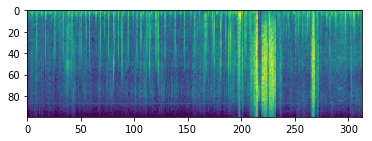

In [247]:
import matplotlib.pyplot as plt

img = X_trn[5][0].reshape(100,313)
plt.imshow(img)

In [244]:
bs = 2532 / 2
bs

1266.0

### mixup

In [245]:
alpha = .3
bs = 1266

if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, 1, 1, 1)
            y_l = l.reshape(bs, 1)
        elif len(X_temp.shape) == 2 :
            _, h = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, 1)
            y_l = l.reshape(bs, 1)
        elif len(X_temp.shape) == 1 :
            _ = X_temp.shape
            l = np.random.beta(alpha, alpha, bs)
            X_l = l.reshape(bs, )
            y_l = l.reshape(bs, 1)

        X1 = X_temp[:bs].copy()
        X2 = X_temp[bs:].copy()
        X.append(X1 * X_l + X2 * (1 - X_l))


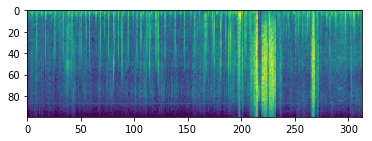

In [250]:
import matplotlib.pyplot as plt

img = X_trn[5][0].reshape(100,313)
plt.imshow(img)

### low frequency feature masking (LF)

In [251]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            
            if [0.5, [10,11,12]] :
                uv, lp = [0.5, [10,11,12]]
                dec1 = np.random.choice(2, size = 2*1266)
                for i in range(2*1266) :
                    loc1 = np.random.choice(lp, size = 1)[0]
                    X_temp[i,:loc1,:,:] = 0
        X1 = X_temp            
        X.append(X1)


In [252]:
X[5][0].shape

(100, 313, 1)

mixup + LF 적용된 피쳐들

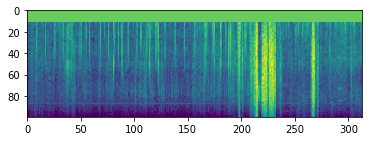

In [253]:
import matplotlib.pyplot as plt

img = X[5][0].reshape(100,313)
plt.imshow(img)

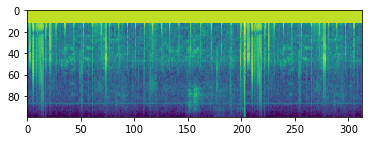

In [254]:
img = X[5][1].reshape(100,313)
plt.imshow(img)

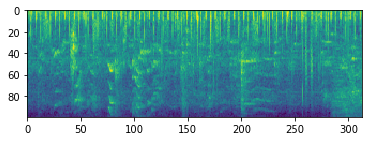

In [255]:
img = X[5][1267].reshape(100,313)
plt.imshow(img)

mixup + LF + HF 적용된 피쳐들

In [256]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, h, w, c = X_temp.shape
            
            if [0.5, [80,81,82]] :
                uv, hp = [0.5, [80,81,82]]
#                dec1 = np.random.choice(2, size = 2*1266, p = uv)
                for i in range(1266) :
                    loc1 = np.random.choice(hp, size = 1)[0]
                    X_temp[i,loc1:,:,:] = 0
        X1 = X_temp            
        X.append(X1)

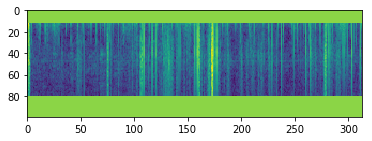

In [257]:
img = X_trn[5][100].reshape(100,313)
plt.imshow(img)

mixup + LF+HF+RF 적용된 피쳐들

In [258]:
if isinstance(X_trn, list):
    X = []
    for X_temp in X_trn:
        if len(X_temp.shape) == 4: 
            _, nf, w, c = X_temp.shape
            
            if [2, [10,11,12]] :
                raniter, ranf = [2, [10,11,12]]
                dec1 = np.random.choice(raniter, size = 2*1266)
                for i in range(2*1266) :
                    if dec1[i] > 0 :
                        for j in range(dec1[i]) :
                            b1 = np.random.choice(ranf, size = 1)[0]
                            loc1 = np.random.choice(nf - b1, size = 1)[0]
                            X_temp[i, loc1:(loc1 + b1 - 1), :] = 0
        X1 = X_temp            
        X.append(X1)

        if self.ranfilter2 :   ## ex ranfilter2 = [4,[10,11,12,13,14,15]]
            raniter, ranf = self.ranfilter2
            dec1 = np.random.choice(raniter, size = self.batch_size)
            for i in range(self.batch_size) :
                if dec1[i] > 0 :
                    for j in range(dec1[i]) :
                        b1 = np.random.choice(ranf, size = 1)[0]
                        loc1 = np.random.choice(nf - b1, size = 1)[0]
                        nX[i, loc1:(loc1 + b1 - 1), :] = 0

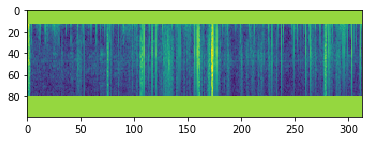

In [259]:
img = X_trn[5][100].reshape(100,313)
plt.imshow(img)

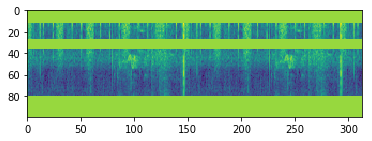

In [263]:
img = X_trn[5][13].reshape(100,313)
plt.imshow(img)

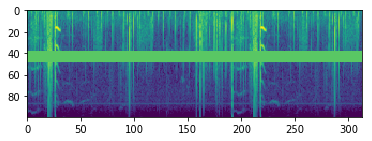

In [269]:
img = X_trn[5][1701].reshape(100,313)
plt.imshow(img)

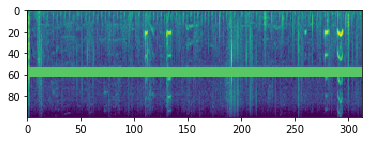

In [271]:
img = X_trn[5][1703].reshape(100,313)
plt.imshow(img)

In [273]:
import os
import sys
import pandas
import numpy
import pickle
import soundfile
import pandas as pd
import numpy as np
import tensorflow
import tensorflow.keras


class Generator0():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, lowpass = False, highpass = False, ranfilter = False, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

        ## ffm 
        self.lowpass = lowpass
        self.highpass = highpass
        self.ranfilter = ranfilter


    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        
        X_trn = self.X_train.copy()
        
        if isinstance(X_trn, list):
            X = []
            for X_temp in X_trn:
                if len(X_temp.shape) == 4: 
                    _, h, w, c = X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1, 1, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 3:
                    _, h, w = self.X_train.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 2:
                    _, h = X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size, 1)
                    y_l = l.reshape(self.batch_size, 1)
                elif len(X_temp.shape) == 1:
                    _= X_temp.shape
                    l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                    X_l = l.reshape(self.batch_size,)
                    y_l = l.reshape(self.batch_size, 1)
                
                X1 = X_temp[batch_ids[:self.batch_size]]
                X2 = X_temp[batch_ids[self.batch_size:]]
                X.append(X1 * X_l + X2 * (1 - X_l))
        else:
            if len(self.X_train.shape) == 4: 
                _, h, w, c = self.X_train.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1, 1, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(self.X_train.shape) == 3:
                _, h, w = self.X_train.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(X_temp.shape) == 2:
                _, h = X_temp.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size, 1)
                y_l = l.reshape(self.batch_size, 1)
            elif len(X_temp.shape) == 1:
                _= X_temp.shape
                l = np.random.beta(self.alpha, self.alpha, self.batch_size)
                X_l = l.reshape(self.batch_size,)
                y_l = l.reshape(self.batch_size, 1)

            X1 = self.X_train[batch_ids[:self.batch_size]]
            X2 = self.X_train[batch_ids[self.batch_size:]]
            X = X1 * X_l + X2 * (1 - X_l)

        if self.lowpass :
            if isinstance(X_trn, list):
                X = []
                for X_temp in X_trn:
                    if len(X_temp.shape) == 4: 
                        _, h, w, c = X_temp.shape

                        if self.lowpass :
                            uv, lp = self.lowpass
                            dec1 = np.random.choice(2, size = 2*self.batch_size)
                            for i in range(2*self.batch_size) :
                                loc1 = np.random.choice(lp, size = 1)[0]
                                X_temp[i,:loc1,:,:] = 0
                    X.append(X_temp)        
                
        if self.highpass :
            if isinstance(X_trn, list):
                X = []
                for X_temp in X_trn:
                    if len(X_temp.shape) == 4: 
                        _, h, w, c = X_temp.shape

                        if self.highpass :
                            uv, hp = self.highpass
                            dec1 = np.random.choice(2, size = 2*self.batch_size)
                            for i in range(2*self.batch_size) :
                                loc1 = np.random.choice(hp, size = 1)[0]
                                X_temp[i,loc1:,:,:] = 0
                    X.append(X_temp)        
                

        if self.ranfilter :                
            if isinstance(X_trn, list):
                X = []
                for X_temp in X_trn:
                    if len(X_temp.shape) == 4: 
                        _, nf, w, c = X_temp.shape

                        if self.ranfilter :
                            raniter, ranf = self.ranfilter
                            dec1 = np.random.choice(raniter, size = 2*self.batch_size)
                            for i in range(2*self.batch_size) :
                                if dec1[i] > 0 :
                                    for j in range(dec1[i]) :
                                        b1 = np.random.choice(ranf, size = 1)[0]
                                        loc1 = np.random.choice(nf - b1, size = 1)[0]
                                        X_temp[i, loc1:(loc1 + b1 - 1), :] = 0
                    X.append(X_temp)            

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]].copy()
                y2 = y_train_[batch_ids[self.batch_size:]].copy()
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]].copy()
            y2 = self.y_train[batch_ids[self.batch_size:]].copy()
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [272]:
features_test[1].shape

(631, 3)

In [296]:
model = get_toy3_1((100, 313, 1))
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 49, 155, 16)  0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 45, 151, 32)  12832       max_pooling2d_36[0][0]           
____________________________________________________________________________________________

In [297]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=100))

In [318]:
TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                          batch_size=64,
                          alpha=0.4 # mixup parameter
                               
                               )()

In [312]:
TrainDGen_1

<generator object Generator0.__call__ at 0x7f9664b29780>

In [ ]:
x, y = next(TrainDGen_1)
cols, rows = 5, 4
img_num = cols * rows

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i].astype(np.uint8), interpolation="nearest")
    plt.axis('off')

In [ ]:
x, y = next(TrainDGen_1)
cols, rows = 5, 4
img_num = cols * rows

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i].astype(np.uint8), interpolation="nearest")
    plt.axis('off')

In [299]:
features_trn[0]['id'].shape[0]

2532

In [300]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,ReduceLROnPlateau

In [ ]:
model.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr, mc],
                             epochs = 50)


In [302]:
mc = ModelCheckpoint('checkpoint.h5', monitor='val_categorical_accuracy',
                          verbose=True, save_best_only=True,
                          mode ='auto', period =1)
    
model.fit(TrainDataGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr, mc],
                             epochs = 50)


StopIteration: 

In [307]:
model.fit([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], features_trn[1],
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
          epochs = 30)

Epoch 1/30
80/80 [==============================] - 18s 228ms/step - loss: 0.5896 - accuracy: 0.7599 - val_loss: 0.5918 - val_accuracy: 0.7448
Epoch 2/30
80/80 [==============================] - 18s 227ms/step - loss: 0.5740 - accuracy: 0.7622 - val_loss: 0.5770 - val_accuracy: 0.7544
Epoch 3/30
80/80 [==============================] - 18s 227ms/step - loss: 0.5571 - accuracy: 0.7733 - val_loss: 0.5900 - val_accuracy: 0.7797
Epoch 4/30
80/80 [==============================] - 18s 227ms/step - loss: 0.5602 - accuracy: 0.7737 - val_loss: 0.5992 - val_accuracy: 0.7591
Epoch 5/30
80/80 [==============================] - 18s 226ms/step - loss: 0.5437 - accuracy: 0.7907 - val_loss: 0.5513 - val_accuracy: 0.7734
Epoch 6/30
80/80 [==============================] - 18s 227ms/step - loss: 0.5366 - accuracy: 0.8006 - val_loss: 0.5485 - val_accuracy: 0.7876
Epoch 7/30
80/80 [==============================] - 18s 226ms/step - loss: 0.5224 - accuracy: 0.8116 - val_loss: 0.5323 - val_accuracy: 0.8019

KeyboardInterrupt: 

In [231]:
import pickle as pk
def save_challenge_model2(model_folder, model, m_name, mel_shape = (100, 313, 1)) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename = os.path.join(model_folder, m_name + '_model.hdf5')
    model.save(filename)
    d = {'model': m_name, 'mel_shape': mel_shape, 'model_fnm': filename}    
    with open(info_fnm, 'wb') as f:
        pk.dump(d, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [232]:
# Save the model.
save_challenge_model2(model_folder, model, m_name = 'toy')

1

In [233]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)
#    if info_m['model'] == 'toy' :
#        model = get_toy(info_m['mel_shape'])
#    filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
#    model.load_weights(filename)
    return info_m

def get_toy(mel_input_shape):
        # Create a towy model.
    age = keras.Input(shape=(6,), name = 'age_cat')
    sex = keras.Input(shape=(2,), name = 'sex_cat')
    hw = keras.Input(shape=(2,), name = 'height_weight')
    preg = keras.Input(shape=(1,), name = 'is_preg')
    loc = keras.Input(shape=(5,), name = 'loc')
    mel1 = keras.Input(shape=(mel_input_shape), name = 'mel')
        
    ## age embeddig
    age1 = layers.Dense(2, activation = 'relu')(age)

    ## sex embedding
    sex1 = layers.Dense(1, activation = 'relu')(sex)

    ## hw embedding
    hw1 = layers.Dense(1, activation = 'relu')(hw)

    ## loc embedding
    loc1 = layers.Dense(3, activation = 'relu')(loc)

    ## mel embedding
    mel2 = layers.Conv2D(16, (3,3), activation = 'relu')(mel1)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (5,5), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(32, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.Conv2D(64, (3,3), activation = 'relu')(mel2)
    mel2 = layers.MaxPooling2D()(mel2)
    mel2 = layers.GlobalAveragePooling2D()(mel2)

    concat1 = layers.Concatenate()([age1, sex1, hw1, loc1, mel2, preg])
    concat1 = layers.Dense(10, activation = 'relu')(concat1)
    concat1 = layers.Dense(3, activation = "softmax")(concat1)
    model = keras.Model(inputs = [age,sex,hw,preg,loc,mel1] , outputs = concat1 )
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

In [120]:
save_challenge_model2(model_folder, model, m_name = 'toy')

1

In [234]:
model2 = load_challenge_model(model_folder, verbose = 1) ### Teams: Implement this function!!!


In [235]:
model2

{'model': 'toy',
 'mel_shape': (100, 313, 1),
 'model_fnm': 'tmp_model2/toy_model.hdf5'}

In [236]:
patient_data = load_patient_data(patient_files_test[0])
recordings = load_recordings(data_folder, patient_data)

In [129]:
data = patient_data

In [ ]:
def run_challenge_model(model, data, recordings, verbose):
    
    if model['model'] == 'toy' :
        model1 = get_toy(model['mel_shape'])
    model1.load_weights(model['model_fnm'])
    
    classes = model['classes']
    # Load features.
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i])[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
#    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

    # Get classifier probabilities.
    prob1 = res1.mean(axis = 0) ## simple rule for now
    idx = np.argmax(prob1)
    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    labels[idx] = 1

    return classes, labels, prob1

In [237]:
model1

{'model': 'toy',
 'mel_shape': (100, 313, 1),
 'model_fnm': 'tmp_model2/toy_model.hdf5'}

In [238]:
    if model1['model'] == 'toy' :
        model2 = get_toy2(model1['mel_shape'])
    model2.load_weights(model1['model_fnm'])
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Normal', 'Abnormal']
    # Load features.
    features = get_feature_one(data, verbose = 0)
    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i])[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
    res1 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res1

In [241]:
    res1 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])


In [242]:
res1

[array([[2.2546257e-16, 1.2601602e-16, 1.0000000e+00],
        [6.9195350e-16, 3.9185369e-16, 1.0000000e+00],
        [1.3673014e-16, 7.5975606e-17, 1.0000000e+00],
        [4.0297731e-17, 2.2074177e-17, 1.0000000e+00]], dtype=float32),
 array([[1.7146952e-09, 1.0000000e+00],
        [3.1972824e-09, 1.0000000e+00],
        [1.2986671e-09, 1.0000000e+00],
        [6.5870259e-10, 1.0000000e+00]], dtype=float32)]

In [243]:
patient_data

'33151 4 4000\nAV 33151_AV.hea 33151_AV.wav 33151_AV.tsv\nPV 33151_PV.hea 33151_PV.wav 33151_PV.tsv\nTV 33151_TV.hea 33151_TV.wav 33151_TV.tsv\nMV 33151_MV.hea 33151_MV.wav 33151_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 141.0\n#Weight: 30.9\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: MV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Plateau\n#Systolic murmur grading: I/VI\n#Systolic murmur pitch: Low\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [ ]:
    if model1['model'] == 'toy' :
        model2 = get_toy2(model1['mel_shape'])
    model2.load_weights(model1['model_fnm'])
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Normal', 'Abnormal']
    # Load features.
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i])[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
#    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

    # Get classifier probabilities.
    prob1 = res1.mean(axis = 0) ## simple rule for now
    idx = np.argmax(prob1)
    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    labels[idx] = 1


In [125]:
def get_feature_one(patient_data, verbose = 0) :

    age_classes = ['Neonate', 'Infant', 'Child', 'Adolescent', 'Young Adult']
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    
    num_locations = get_num_locations(patient_data)
    recording_information = patient_data.split('\n')[1:num_locations+1]

    features = dict()
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
#    features['mel1'] = []
    for j in range(num_locations) :
        entries = recording_information[j].split(' ')
        recording_file = entries[2]
#        filename = os.path.join(data_folder, recording_file)

        # Extract id
    #    id1 = recording_file.split('_')[0]
    #    features['id'].append(id1)

        # Extract melspec
#        mel1 = feature_extract_melspec(filename)[0]
#        features['mel1'].append(mel1)

        # Extract age_group
        age_group = get_age(patient_data)
        current_age_group = np.zeros(6, dtype=int)
        if age_group in age_classes:
            j = age_classes.index(age_group)
            current_age_group[j] = 1
        else :
            current_age_group[5] = 1
        features['age'].append(current_age_group)

        # Extract sex
        sex = get_sex(patient_data)
        sex_features = np.zeros(2, dtype=int)
        if compare_strings(sex, 'Female'):
            sex_features[0] = 1
        elif compare_strings(sex, 'Male'):
            sex_features[1] = 1
        features['sex'].append(sex_features)

        # Extract height and weight.
        height = get_height(patient_data)
        weight = get_weight(patient_data)
        features['hw'].append(np.array([height, weight]))

        # Extract pregnancy
        is_pregnant = get_pregnancy_status(patient_data)
        features['preg'].append(is_pregnant)

        # Extract location
        locations = entries[0]
        num_recording_locations = len(recording_locations)
        loc_features = np.zeros(num_recording_locations)
        if locations in recording_locations:
            j = recording_locations.index(locations)
            loc_features[j] = 1
        features['loc'].append(loc_features)
        

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
        
    if verbose :
        label = get_label(patient_data)
        print(label)
    return features

In [128]:
patient_data

'33151 4 4000\nAV 33151_AV.hea 33151_AV.wav 33151_AV.tsv\nPV 33151_PV.hea 33151_PV.wav 33151_PV.tsv\nTV 33151_TV.hea 33151_TV.wav 33151_TV.tsv\nMV 33151_MV.hea 33151_MV.wav 33151_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 141.0\n#Weight: 30.9\n#Pregnancy status: False\n#Murmur: Present\n#Murmur locations: MV+TV\n#Most audible location: TV\n#Systolic murmur timing: Holosystolic\n#Systolic murmur shape: Plateau\n#Systolic murmur grading: I/VI\n#Systolic murmur pitch: Low\n#Systolic murmur quality: Harsh\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Outcome: Abnormal\n#Campaign: CC2015\n#Additional ID: nan\n'

In [130]:
murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Normal', 'Abnormal']
num_mm_classes = len(murmur_classes)
num_o_classes = len(outcome_classes)

if model1['model'] == 'toy' :
    model2 = get_toy(model1['mel_shape'])
model2.load_weights(model1['model_fnm'])

features = get_feature_one(data, verbose = 0)

In [131]:
recordings

[array([ -455,  1009,   729, ..., -2099, -1931, -1825], dtype=int16),
 array([1174, 4679, 5900, ...,  -36, -171,  -73], dtype=int16),
 array([7710, 5756, 2397, ...,  950,  784,  923], dtype=int16),
 array([14951,  7497,  -352, ...,  1297,   811,    61], dtype=int16)]

In [132]:
features['mel1'] = []
for i in range(len(recordings)) :
    mel1 = feature_extract_melspec(recordings[i])[0]
    features['mel1'].append(mel1)

In [133]:
M, N = features['mel1'][0].shape
for i in range(len(features['mel1'])) :
    features['mel1'][i] = features['mel1'][i].reshape(M,N,1) 

In [135]:
features['mel1'] = np.array(features['mel1'])
#    print(features)
# Impute missing data.
res1 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

In [136]:
res1

[array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=float32),
 array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=float32)]

In [ ]:
murmur_classes = ['Present', 'Unknown', 'Absent']
outcome_classes = ['Normal', 'Abnormal']
num_mm_classes = len(murmur_classes)
num_o_classes = len(outcome_classes)

if model['model'] == 'toy' :
    model1 = get_toy(model['mel_shape'])
model1.load_weights(model['model_fnm'])

features = get_feature_one(data, verbose = 0)


#imputer = model['imputer']
classifier = model['classifier']

if model['model'] == 'toy' :
    model1 = get_toy(info_m['mel_shape'])
filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
model.load_weights(filename)

# Load features.
features = get_features(data, recordings)

# Impute missing data.
features = features.reshape(1, -1)
features = imputer.transform(features)

# Get classifier probabilities.
probabilities = classifier.predict_proba(features)
probabilities = np.asarray(probabilities, dtype=np.float32)[:, 0, 1]

# Choose label with higher probability.
labels = np.zeros(len(classes), dtype=np.int_)
idx = np.argmax(probabilities)
labels[idx] = 1


In [393]:
classes, labels, probabilities = run_challenge_model(model1, patient_data, recordings, verbose) ### Teams: Implement this function!!!


NameError: name 'run_challenge_model' is not defined

In [333]:
num_locations = get_num_locations(patient_data)
recording_information = current_patient_data.split('\n')[1:num_locations+1]


In [336]:
features = dict()
features['age'] = []
features['sex'] = []
features['hw'] = []
features['preg'] = []
features['loc'] = []
features['mel1'] = []
for j in range(num_locations) :
    entries = recording_information[j].split(' ')
    recording_file = entries[2]
    filename = os.path.join(data_folder, recording_file)

    # Extract id
#    id1 = recording_file.split('_')[0]
#    features['id'].append(id1)

    # Extract melspec
    mel1 = feature_extract_melspec(filename)[0]
    features['mel1'].append(mel1)

    # Extract age_group
    age_group = get_age(current_patient_data)
    current_age_group = np.zeros(6, dtype=int)
    if age_group in age_classes:
        j = age_classes.index(age_group)
        current_age_group[j] = 1
    else :
        current_age_group[5] = 1
    features['age'].append(current_age_group)

    # Extract sex
    sex = get_sex(current_patient_data)
    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1
    features['sex'].append(sex_features)

    # Extract height and weight.
    height = get_height(current_patient_data)
    weight = get_weight(current_patient_data)
    features['hw'].append(np.array([height, weight]))

    # Extract pregnancy
    is_pregnant = get_pregnancy_status(current_patient_data)
    features['preg'].append(is_pregnant)

    # Extract location
    locations = entries[0]
    num_recording_locations = len(recording_locations)
    loc_features = np.zeros(num_recording_locations)
    if locations in recording_locations:
        j = recording_locations.index(locations)
        loc_features[j] = 1
    features['loc'].append(loc_features)

In [342]:
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])

In [346]:
features.keys()

dict_keys(['age', 'sex', 'hw', 'preg', 'loc', 'mel1'])

In [348]:
res1 = model.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

In [352]:
res1.argmax(axis=1)

array([2, 2, 2, 2])

In [353]:
res1

array([[1.2032033e-03, 2.9272465e-03, 9.9586958e-01],
       [3.2206599e-02, 7.0056088e-02, 8.9773726e-01],
       [1.4683392e-04, 7.0860866e-04, 9.9914455e-01],
       [1.8912905e-03, 6.9301804e-03, 9.9117857e-01]], dtype=float32)

In [355]:
features_test[1][:4]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [354]:
features_test[1][0]

array([1, 0, 0])

In [354]:
features_test[1][0]

array([1, 0, 0])

In [354]:
features_test[1][0]

array([1, 0, 0])

In [354]:
features_test[1][0]

array([1, 0, 0])

In [369]:
classes

['Present', 'Unknown', 'Absent']

In [81]:
def run_challenge_model(model, data, recordings, verbose):
    classes = model['classes']
    imputer = model['imputer']
    classifier = model['classifier']

    if model['model'] == 'toy' :
        model1 = get_toy(info_m['mel_shape'])
    filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
    model.load_weights(filename)
    
    # Load features.
    features = get_features(data, recordings)

    # Impute missing data.
    features = features.reshape(1, -1)
    features = imputer.transform(features)

    # Get classifier probabilities.
    probabilities = classifier.predict_proba(features)
    probabilities = np.asarray(probabilities, dtype=np.float32)[:, 0, 1]

    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    idx = np.argmax(probabilities)
    labels[idx] = 1

    return classes, labels, probabilities

In [372]:
model

{'model': 'toy',
 'classes': ['Present', 'Unknown', 'Absent'],
 'mel_shape': (100, 313, 1)}

In [86]:
patient_data = load_patient_data(patient_files_test[1])
recordings = load_recordings(data_folder, patient_data)

In [87]:
features_test[1][:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [88]:
patient_data

'85112 4 4000\nAV 85112_AV.hea 85112_AV.wav 85112_AV.tsv\nPV 85112_PV.hea 85112_PV.wav 85112_PV.tsv\nTV 85112_TV.hea 85112_TV.wav 85112_TV.tsv\nMV 85112_MV.hea 85112_MV.wav 85112_MV.tsv\n#Age: Child\n#Sex: Male\n#Height: 136.0\n#Weight: 26.3\n#Pregnancy status: False\n#Murmur: Absent\n#Murmur locations: nan\n#Most audible location: nan\n#Systolic murmur timing: nan\n#Systolic murmur shape: nan\n#Systolic murmur grading: nan\n#Systolic murmur pitch: nan\n#Systolic murmur quality: nan\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Campaign: CC2015\n#Additional ID: nan'

In [ ]:
classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!


In [89]:
classes

['Present', 'Unknown', 'Absent']

In [90]:
current_patient_data

'2530 4 4000\nAV 2530_AV.hea 2530_AV.wav 2530_AV.tsv\nPV 2530_PV.hea 2530_PV.wav 2530_PV.tsv\nTV 2530_TV.hea 2530_TV.wav 2530_TV.tsv\nMV 2530_MV.hea 2530_MV.wav 2530_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 98.0\n#Weight: 15.9\n#Pregnancy status: False\n#Murmur: Absent\n#Murmur locations: nan\n#Most audible location: nan\n#Systolic murmur timing: nan\n#Systolic murmur shape: nan\n#Systolic murmur grading: nan\n#Systolic murmur pitch: nan\n#Systolic murmur quality: nan\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Campaign: CC2015\n#Additional ID: nan'

In [91]:
num_locations = get_num_locations(patient_data)
recording_information = patient_data.split('\n')[1:num_locations+1]


In [92]:

features = dict()
features['age'] = []
features['sex'] = []
features['hw'] = []
features['preg'] = []
features['loc'] = []
features['mel1'] = []
for j in range(num_locations) :
    entries = recording_information[j].split(' ')
    recording_file = entries[2]
    filename = os.path.join(data_folder, recording_file)

    # Extract id
#    id1 = recording_file.split('_')[0]
#    features['id'].append(id1)

    # Extract melspec
    mel1 = feature_extract_melspec(filename)[0]
    features['mel1'].append(mel1)

    # Extract age_group
    age_group = get_age(patient_data)
    current_age_group = np.zeros(6, dtype=int)
    if age_group in age_classes:
        j = age_classes.index(age_group)
        current_age_group[j] = 1
    else :
        current_age_group[5] = 1
    features['age'].append(current_age_group)

    # Extract sex
    sex = get_sex(patient_data)
    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1
    features['sex'].append(sex_features)

    # Extract height and weight.
    height = get_height(patient_data)
    weight = get_weight(patient_data)
    features['hw'].append(np.array([height, weight]))

    # Extract pregnancy
    is_pregnant = get_pregnancy_status(patient_data)
    features['preg'].append(is_pregnant)

    # Extract location
    locations = entries[0]
    num_recording_locations = len(recording_locations)
    loc_features = np.zeros(num_recording_locations)
    if locations in recording_locations:
        j = recording_locations.index(locations)
        loc_features[j] = 1
    features['loc'].append(loc_features)

In [93]:
features

{'age': [array([0, 0, 1, 0, 0, 0]),
  array([0, 0, 1, 0, 0, 0]),
  array([0, 0, 1, 0, 0, 0]),
  array([0, 0, 1, 0, 0, 0])],
 'sex': [array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])],
 'hw': [array([136. ,  26.3]),
  array([136. ,  26.3]),
  array([136. ,  26.3]),
  array([136. ,  26.3])],
 'preg': [False, False, False, False],
 'loc': [array([1., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0.]),
  array([0., 0., 0., 1., 0.]),
  array([0., 1., 0., 0., 0.])],
 'mel1': [array([[  5.5544219 ,   5.25430448,   5.85624965, ...,  -4.01180172,
           -2.62854908,  -2.5042349 ],
         [ 10.42099442,   9.87717865,  14.38695231, ...,  -2.46004349,
            1.79924639,  -4.51349842],
         [ 11.33310424,  13.78394537,  13.1335616 , ...,   1.08339154,
           -1.01365032,  -7.04751297],
         ...,
         [-18.90015848, -54.90594607, -58.1136186 , ..., -59.42052707,
          -56.90998361, -48.85066669],
         [-15.42566047, -52.71301415, -60.73131942, ..., -58.35870

In [94]:
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])

In [85]:
def get_feature_one(patient_data, verbose = 0) :
    num_locations = get_num_locations(patient_data)
    recording_information = patient_data.split('\n')[1:num_locations+1]

    features = dict()
    features['age'] = []
    features['sex'] = []
    features['hw'] = []
    features['preg'] = []
    features['loc'] = []
    features['mel1'] = []
    for j in range(num_locations) :
        entries = recording_information[j].split(' ')
        recording_file = entries[2]
        filename = os.path.join(data_folder, recording_file)

        # Extract id
    #    id1 = recording_file.split('_')[0]
    #    features['id'].append(id1)

        # Extract melspec
        mel1 = feature_extract_melspec(filename)[0]
        features['mel1'].append(mel1)

        # Extract age_group
        age_group = get_age(patient_data)
        current_age_group = np.zeros(6, dtype=int)
        if age_group in age_classes:
            j = age_classes.index(age_group)
            current_age_group[j] = 1
        else :
            current_age_group[5] = 1
        features['age'].append(current_age_group)

        # Extract sex
        sex = get_sex(patient_data)
        sex_features = np.zeros(2, dtype=int)
        if compare_strings(sex, 'Female'):
            sex_features[0] = 1
        elif compare_strings(sex, 'Male'):
            sex_features[1] = 1
        features['sex'].append(sex_features)

        # Extract height and weight.
        height = get_height(patient_data)
        weight = get_weight(patient_data)
        features['hw'].append(np.array([height, weight]))

        # Extract pregnancy
        is_pregnant = get_pregnancy_status(patient_data)
        features['preg'].append(is_pregnant)

        # Extract location
        locations = entries[0]
        num_recording_locations = len(recording_locations)
        loc_features = np.zeros(num_recording_locations)
        if locations in recording_locations:
            j = recording_locations.index(locations)
            loc_features[j] = 1
        features['loc'].append(loc_features)
        
        
    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)

    for k1 in features.keys() :
        features[k1] = np.array(features[k1])
        
    if verbose :
        label = get_label(patient_data)
        print(label)
    return features

In [433]:
features.keys()

dict_keys(['age', 'sex', 'hw', 'preg', 'loc', 'mel1'])

In [95]:
res1 = model.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

In [96]:
res1.argmax(axis=1)

array([0, 2, 2, 2])

In [100]:
prob1 = res1.mean(axis = 0)

In [101]:
probargmax = prob1.argmax()
labels = np.zeros((3,))
labels[probargmax] = 1

In [102]:
labels

array([0., 0., 1.])

In [103]:
classes

['Present', 'Unknown', 'Absent']

In [440]:
model1

{'model': 'toy',
 'classes': ['Present', 'Unknown', 'Absent'],
 'mel_shape': (100, 313, 1),
 'model_fnm': 'tmp_model1/toy_model.hdf5'}

In [84]:
model1

{'model': 'toy',
 'classes': ['Present', 'Unknown', 'Absent'],
 'mel_shape': (100, 313, 1),
 'model_fnm': 'tmp_model1/toy_model.hdf5'}

In [109]:
#classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!
def run_challenge_model(model, data, recordings, verbose):
    
    
    
    if model['model'] == 'toy' :
        model1 = get_toy(model['mel_shape'])
    filename = os.path.join(model_folder, model['model'] + '_model.hdf5')
    model1.load_weights(filename)
    
    classes = model['classes']
    # Load features.
    features = get_feature_one(data, verbose)

    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    

    # Get classifier probabilities.
    prob1 = res1.mean(axis = 0) ## simple rule for now
    idx = np.argmax(prob1)
    # Choose label with higher probability.
    labels = np.zeros(len(classes), dtype=np.int_)
    labels[idx] = 1

    return classes, labels, prob1

In [105]:
len(patient_files_test)

142

In [110]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[0]), recordings = 0, verbose = 1)

Present


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.42289853, 0.02808568, 0.5490158 ], dtype=float32))

In [111]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[1]), recordings = 0, verbose = 1)

Absent


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.21346666, 0.03261768, 0.7539156 ], dtype=float32))

In [112]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[2]), recordings = 0, verbose = 1)

Absent


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.11145334, 0.01811697, 0.8704297 ], dtype=float32))

In [113]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[3]), recordings = 0, verbose = 1)

Absent


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.09037623, 0.00931931, 0.90030444], dtype=float32))

In [114]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[4]), recordings = 0, verbose = 1)

Absent


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.04683066, 0.00709078, 0.94607854], dtype=float32))

In [115]:

ones1 = []
for i in range(100) :
    patient_data = load_patient_data(patient_files_test[i])
    num_locations = get_num_locations(patient_data)
    if(num_locations == 1) :
        ones1.append(i)
    

In [116]:
ones1

[24, 32, 80, 94, 98]

In [117]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[24]), recordings = 0, verbose = 1)

Present


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.02266924, 0.06886302, 0.90846777], dtype=float32))

In [118]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[32]), recordings = 0, verbose = 1)

Unknown


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([5.9274078e-04, 1.3342367e-02, 9.8606491e-01], dtype=float32))

In [119]:
run_challenge_model(model1, data = load_patient_data(patient_files_test[80]), recordings = 0, verbose = 1)

Absent


(['Present', 'Unknown', 'Absent'],
 array([0, 0, 1]),
 array([0.01424488, 0.0106928 , 0.97506225], dtype=float32))